# IBM Applied Data Science Capstone // Week 3
### IBM Data Science Specialization
#### by Yohann Rousselet

This workbook will be used to complete the IBM Applied Data Science Capstone, which is Course 9 of 9 in the IBM Data Science Specialization

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Geolocation](#geo)
* [Explore Neighborhoods](#explore)
* [Cluster Neighborhoods](#cluster)
* [Conclusions](#conclusion)

## Introduction <a name="introduction"></a>

The purpose of this assignment, you will be required to explore and cluster the neighborhoods in Toronto.

## Data <a name="data"></a>

The source data for this notebook will be scraped from **Wikipedia** (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M).

More specifically, the data will be obtained from the table of postal codes and transformed into a **pandas dataframe**.

#### Load required libraries

In [1]:
import pandas as pd
import numpy as np

#### Scrape data

In [2]:
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]

#### Ignore cells with a borough that is 'Not assigned'

In [3]:
df.drop(df[df['Borough'] == 'Not assigned'].index, inplace = True)
df.reset_index(drop=True, inplace = True)

#### Replace ' / ' by ' , ' in Neighborhood column

In [4]:
df['Neighborhood'] = df['Neighborhood'].str.replace(' /', ',')

#### Replace 'Not assigned' Neighborhood with Borough

In [5]:
df.loc[(df.Neighborhood == 'Not asigned'),'Neighborhood']= df['Borough']
df.rename(columns={"Postal code": "Postal Code"}, inplace = True)
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### Display number of rows of Dataframe 

In [6]:
print("Numbers of rows =",df.shape[0])

Numbers of rows = 103


## Geolocation <a name="geo"></a>

Now that a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name is was created, we need to get the **latitude** and the **longitude** coordinates of each neighborhood to be able to utilize the **Foursquare location data**. 

#### Loop through Dataframe and get coordinates (not used; see below)

In [ ]:
 !pip -q install geocoder

import geocoder # import geocoder

#Create function to find coordinates for given postal code
def geoloc(PostCD):

    # initialize your variable to None
    lat_lng_coords = None
    
    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.arcgis('{}, Toronto, Ontario'.format(PostCD))
      lat_lng_coords = g.latlng

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    
    return latitude, longitude                      

#loop through all postal codes to find coordinates and populate dataframe
df['Latitude'], df['Longitude'] = zip(*df['Postal code'].apply(geoloc))

#### Using csv file to get Postal Code coordinates (saves compute time!)

In [7]:
#Define url
url='http://cocl.us/Geospatial_data'

#Load CSV
pcode_df = pd.read_csv(url)
pcode_df.head()

#Merge Dataframes
df_with_pcode = pd.merge(df, pcode_df, how='inner', on='Postal Code', sort=False)

#### Display first 5 rows of Dataframe with longitude and latitude data

In [8]:
df_with_pcode.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


#### Display number of rows of Dataframe with longitude and latitude data 

In [9]:
print("Numbers of rows =",df_with_pcode.shape[0])

Numbers of rows = 103


## Explore Neighborhoods <a name="explore"></a>

Using Foursquare API, **similar venues** in a given neighborhood will be explored. The Folium library will be used to visualize the neighborhoods in Toronto, and the **top 10 venue types** per neighborohood will be computed into a new Dataframe. This Dataframe will serve as the basis for **clustering** the neighborhoods.

#### Number of Boroughs in Toronto dataframe

In [10]:
print('The Toronto dataframe has {} boroughs.'.format(len(df_with_pcode['Borough'].unique())))

The Toronto dataframe has 10 boroughs.


#### Use geopy library to get the latitude and longitude values of Toronto

In [11]:
#Import necessary library
from geopy.geocoders import Nominatim

#Find coordinates for Toronto
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="Toronto_Test")
location = geolocator.geocode(address)
TOR_lat = location.latitude
TOR_long = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(TOR_lat, TOR_long))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top

In [12]:
#Import necessary library
!pip -q install folium
import folium

#Create map of Toronto using latitude and longitude values
map_toronto = folium.Map(width=750,height=500, location=[TOR_lat, TOR_long], zoom_start=10)

#Add markers to map
for lat, lng, borough, neighborhood in zip(df_with_pcode['Latitude'], df_with_pcode['Longitude'], df_with_pcode['Borough'], df_with_pcode['Neighborhood']):
    label = 'Neighborhood(s): {}, Borough: {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        #radius=5,
        popup=label,
        icon=folium.Icon(color='blue'),
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Load Foursquare credentials

In [13]:
# @hidden_cell 
CLIENT_ID = 'EXECGQ3CD5X1YYKTS0DUCYX3VTYIGBICIZPL1AIJJBWX3WW4' #Foursquare ID
CLIENT_SECRET = '4ARY0Q2DHUJAXKYC5K15WC3FRBLKDD4NM0VZE3RDDVKAPY1W' #Foursquare Secret
VERSION = '20180605' #Foursquare API version

#### Function to get venues to all the neighborhoods in Manhattan
*Radius limted to 500m given the density of neighborhoods, but high number of venues selected (150) to gain as much insight as possible*

In [14]:
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

def getNearbyVenues(names, latitudes, longitudes):

    radius=500
    limit=150
        
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Create Dataframe of venues in Toronto

In [15]:
Tor_venues = getNearbyVenues(names = df_with_pcode['Neighborhood'], latitudes = df_with_pcode['Latitude'], longitudes=df_with_pcode['Longitude'])

#### Explore Dataframe

Group venues by neighborhood (showing first 10 rows only)

In [16]:
Tor_venues.groupby('Neighborhood').count().head(10)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
Berczy Park,55,55,55,55,55,55
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
Business reply mail Processing CentrE,16,16,16,16,16,16


Identify the number of unique venue types

In [17]:
print('There are {} uniques categories.'.format(len(Tor_venues['Venue Category'].unique())))

There are 268 uniques categories.


**That is way too many venue types!!!** Let's reduce dataframe size by selecting the top 5 most common venues per neighborhood

Use **One Hot Encoding** to simplify data exploration

In [38]:
#One hot encoding
Tor_onehot = pd.get_dummies(Tor_venues[['Venue Category']], prefix="", prefix_sep="")

#Add neighborhood column back to dataframe
Tor_onehot['Neighborhood'] = Tor_venues['Neighborhood'] 

#Move neighborhood column to the first column
new_neigh = Tor_onehot['Neighborhood']
Tor_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
Tor_onehot.insert(0, 'Neighborhood', new_neigh)

To help identify the most common venue types for each neighborhood, first group rows by neighborhood and take the mean of the frequency of occurrence of each category (i.e. venue type)

In [39]:
Tor_grouped = Tor_onehot.groupby('Neighborhood').mean().reset_index()
Tor_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can now compute the **5 most common venues** for each neighborhood, which we will use to cluster the neighborhoods

In [40]:
#Function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Tor_neigh_venues_sorted = pd.DataFrame(columns=columns)
Tor_neigh_venues_sorted['Neighborhood'] = Tor_grouped['Neighborhood']

for ind in np.arange(Tor_grouped.shape[0]):
    Tor_neigh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Tor_grouped.iloc[ind, :], num_top_venues)

Display the first 5 rows of the **top 5 most common venues** for each neighborhood

In [41]:
Tor_neigh_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Latin American Restaurant,Skating Rink,Breakfast Spot,Lounge,Eastern European Restaurant
1,"Alderwood, Long Branch",Pizza Place,Dance Studio,Pharmacy,Sandwich Place,Pub
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Ice Cream Shop,Restaurant,Sushi Restaurant
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Distribution Center
4,"Bedford Park, Lawrence Manor East",Restaurant,Sandwich Place,Italian Restaurant,Pizza Place,Coffee Shop


## Cluster Neighborhoods <a name="cluster"></a>

Similar venues in a given neighborhood will be clustered together, using the k-means clustering algorithm. The Folium library will be used to visualize the neighborhoods in Toronto and their emerging clusters. Based on this clustering, one can easily determine what type of neighborhoods to go to for given a venue of interest.

#### Find optimal k value

First, we build the clustering model and calculate the values of the **Distortion** and **Inertia**, for k between 1 to 10. 

In [42]:
#Import necessary library
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist

#Initiate values
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
Tor_grouped_clustering = Tor_grouped.drop('Neighborhood', 1)

#Fit the model for k between 1 and 10
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(Tor_grouped_clustering)
    kmeanModel.fit(Tor_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(Tor_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / Tor_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(Tor_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / Tor_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

We can then using the different values of **Inertia** and the **elbow method** to determine the optimal k value

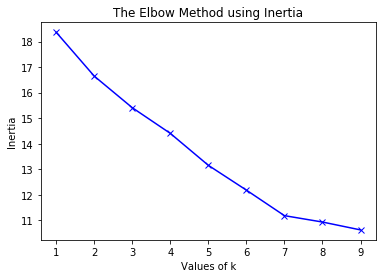

In [43]:
#Import necessary library
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of k') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

It appears that a slight elbow occurs at k = 7; we will then use this value moving forward

#### Generate clusters

We then use the **k-means algorithm** to cluster the neighborhood into **7 clusters**.

In [44]:
#Set number of clusters
kclusters = 7

#Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tor_grouped_clustering)

#Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 5, 4, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 4,
       0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       4, 0, 0, 0, 0, 4], dtype=int32)

A large number of neighborhoods are part of cluster 0; this means that the data might need to be processed differently, but let's plot it to visualize it.

#### Visualize clusters

First, we create a Dataframe containing the clusters that were just created

In [45]:
#Add clustering labels
Tor_neigh_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Tor_merged = df_with_pcode

#Merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Tor_merged = Tor_merged.join(Tor_neigh_venues_sorted.set_index('Neighborhood'), on='Neighborhood').dropna()

Tor_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,4.0,Park,Food & Drink Shop,Falafel Restaurant,Event Space,Ethiopian Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Hockey Arena,Intersection,Pizza Place,Coffee Shop,Portuguese Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Pub,Bakery,Park,Mexican Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Furniture / Home Store,Accessories Store,Clothing Store,Coffee Shop,Event Space
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,Coffee Shop,Yoga Studio,Restaurant,Bar,Beer Bar


Then, we visualize the resulting clusters

In [52]:
#Import necessary library
import matplotlib.cm as cm
import matplotlib.colors as colors

#Create map
map_tor_clusters = folium.Map(width=750,height=500, location=[TOR_lat, TOR_long], zoom_start=10)

#Set color scheme for the clusters
clr_options = ['red', 'blue', 'green', 'gray', 'pink', 'black', 'darkblue', 'beige', 'purple', 'darkgreen', 'darkred']

#Add markers to the map
markers_colors = []
for lat, lng, borough, neighborhood, cluster in zip(Tor_merged['Latitude'], Tor_merged['Longitude'], Tor_merged['Borough'], Tor_merged['Neighborhood'], Tor_merged['Cluster Labels']):
    label0 = 'Cluster: {}, '.format(int(cluster))
    label1 = 'Neighborhood(s): {}, Borough: {}'.format(neighborhood, borough)
    label2 = label0 + label1
    label = folium.Popup(label2, parse_html=True)
    folium.Marker(
        [lat, lng],
        #radius=5,
        popup=label,
        icon=folium.Icon(color=clr_options[int(cluster)]),
        parse_html=False).add_to(map_tor_clusters)  
       
map_tor_clusters

As expected, a large number of neighborhoods fall within the first cluster (label 0). Let's further explore these clusters to see how they are "built"

#### Explore clusters

Let's examine each cluster and determine the discriminating venue categories that distinguish each one.

First, create a new grouped 'One Hot Encoding' Dataframe were Neighborhoods are replaced by Cluster Labels 

In [76]:
#Create new Dataframe
Tor_cluster_vs_neigh = pd.DataFrame(columns=['Neighborhood', 'Cluster Labels'])
Tor_cluster_vs_neigh['Neighborhood']=Tor_merged['Neighborhood']
Tor_cluster_vs_neigh['Cluster Labels']=Tor_merged['Cluster Labels']

#Merge Dataframes
Tor_onehot_with_clusters = pd.merge(Tor_onehot, Tor_cluster_vs_neigh, how='inner', on='Neighborhood', sort=False)
Tor_onehot_with_clusters.head()

#Move 'Cluster Labels' column to the first column
new_cluster = Tor_onehot_with_clusters['Cluster Labels']
Tor_onehot_with_clusters.drop(labels=['Cluster Labels'], axis=1,inplace = True)
Tor_onehot_with_clusters.insert(0, 'Cluster Labels', new_cluster)

#Drop 'Neighborhood'
Tor_onehot_with_clusters = Tor_onehot_with_clusters.drop('Neighborhood', 1)
Tor_onehot_with_clusters.head()

#Group by 'Cluster Label'
Tor_grouped_with_clusters = Tor_onehot_with_clusters.groupby('Cluster Labels').mean().reset_index()
Tor_grouped_with_clusters.head(7)

,Cluster Labels,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.000879,0.000439,0.002197,0.000439,0.000439,0.000879,0.000879,0.000879,0.013181,...,0.000439,0.007469,0.001318,0.000439,0.005272,0.000439,0.004394,0.000439,0.001318,0.005712
1,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000
5,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


We then now compute the **5 most common venues** for each cluster

In [79]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Tor_cluster_venues_sorted = pd.DataFrame(columns=columns)
Tor_cluster_venues_sorted['Cluster Labels'] = Tor_grouped_with_clusters['Cluster Labels']

for ind in np.arange(Tor_grouped_with_clusters.shape[0]):
    Tor_cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Tor_grouped_with_clusters.iloc[ind, :], num_top_venues)
    
Tor_cluster_venues_sorted.head(7)

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0.0,Coffee Shop,Café,Restaurant,Pizza Place,Park
1,1.0,Golf Course,Yoga Studio,Dumpling Restaurant,Discount Store,Distribution Center
2,2.0,Baseball Field,Construction & Landscaping,Yoga Studio,Eastern European Restaurant,Dog Run
3,3.0,Empanada Restaurant,Yoga Studio,Diner,Farmers Market,Falafel Restaurant
4,4.0,Park,Convenience Store,Playground,Coffee Shop,Food & Drink Shop
5,5.0,Fast Food Restaurant,Diner,Farmers Market,Falafel Restaurant,Event Space
6,6.0,Playground,Summer Camp,Yoga Studio,Discount Store,Distribution Center


It is indeed difficult to distinguish between clusters. Some work is required for valuable insights to be gained from studying this dataset.

## Conclusions <a name="conclusion"></a>

#### In this workbook, we succesfully:
- Compiled and explored data on neighborhoods in Toronto
- Used the Foursquare API to obtain data on venues in each neighborhood
- Sorted the neighborhoods and clustered them using the k-means algorithm
- Displayed the cluster and neighborhoods on an interactive map

*While this insights gained were limited, this was a good practice exercise before completing the final assignement*